# Подготовка

Установка пакетов:
- torch, torchvision: для обучения нейронной сети,
- pandas: для чтения данных из CSV-таблицы,
- matplotlib, geopy, basemap: для построения графиков и карт,
- scikit-learn: инструменты статистики,
- tqdm: вспомогательная библиотека для отслеживания долгих циклов.

In [1]:
!pip install --upgrade torch torchvision tqdm pandas matplotlib scikit-learn geopy basemap  # установка пакетов из репозитория PyPI, причём пакеты torch, torchvision берутся из отдельного репозитория для CUDA 11.6
# --extra-index-url https://download.pytorch.org/whl/cu116 -- добавьте эту строку, если установлена библиотека CUDA 11.6, тогда нейросеть будет работать быстрее
!pip install --upgrade "numpy<1.24"  # установка подходящей версии пакета numpy

Requirement already up-to-date: torch in /usr/local/lib/python3.8/dist-packages (1.13.1+cu116)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.8/dist-packages (0.14.1+cu116)
Requirement already up-to-date: tqdm in /usr/local/lib/python3.8/dist-packages (4.64.1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.8/dist-packages (1.5.3)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.8/dist-packages (3.7.0)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.8/dist-packages (1.2.1)
Requirement already up-to-date: geopy in /usr/local/lib/python3.8/dist-packages (2.3.0)
Requirement already up-to-date: basemap in /usr/local/lib/python3.8/dist-packages (1.3.6)
Requirement already up-to-date: numpy<1.24 in /usr/local/lib/python3.8/dist-packages (1.23.5)


Подключение необходимых пакетов:

In [142]:
import time 

import numpy as np    
import pandas as pd  
import torch          
from torch import nn, optim  
from torch.utils.data import TensorDataset, DataLoader  
from sklearn import preprocessing           
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt              
from mpl_toolkits.basemap import Basemap    
from tqdm import tqdm                       
from geopy.distance import distance, lonlat

%matplotlib inline
# графики будут выводиться в тексте документа, а не в отдельном окне

# Работа с данными

Загрузка датасета из файла CSV, вывод общих сведений на экран:

In [3]:
atlantic = pd.read_csv('data/atlantic.csv', sep=',') 
atlantic 

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,20151112,1200,,EX,41.3N,50.4W,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,1800,,EX,41.9N,49.9W,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,0,,EX,41.5N,49.2W,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,600,,EX,40.8N,47.5W,45,985,...,180,220,0,0,0,0,0,0,0,0


В данной таблице почти все значения числовые. Но необходимые поля "широта, долгота" (latitude, longitude) записаны в формате "значение угла в градусах, полушарие". Приведём данные к числовому виду, отбросив букву и поменяв знак у значений долготы (отсчёт от 0 меридиана):

In [4]:
def transform_geo_float(val):  # функция преобразования географической координаты из строки в число
    num = float(val[:-1])     
    if val[-1] in ('S', 'W'): 
        num = -num            
    return num  

In [5]:
atlantic['Latitude'] = atlantic['Latitude'].apply(transform_geo_float)   
atlantic['Longitude'] = atlantic['Longitude'].apply(transform_geo_float) 
atlantic  

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0,-94.8,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0,-95.4,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0,-96.0,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1,-96.5,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2,-96.8,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,20151112,1200,,EX,41.3,-50.4,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,1800,,EX,41.9,-49.9,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,0,,EX,41.5,-49.2,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,600,,EX,40.8,-47.5,45,985,...,180,220,0,0,0,0,0,0,0,0


Видно также, что много данных содержат недостоверное значение ветра (-999). Заполним все значения ветра 0 там, где значение сейчас меньше 0:

In [6]:
for col in atlantic.columns:  
    if 'wind' in col.lower():  
        atlantic[col] = np.clip(atlantic[col], 0, None) 
atlantic 

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0,-94.8,80,-999,...,0,0,0,0,0,0,0,0,0,0
1,AL011851,UNNAMED,18510625,600,,HU,28.0,-95.4,80,-999,...,0,0,0,0,0,0,0,0,0,0
2,AL011851,UNNAMED,18510625,1200,,HU,28.0,-96.0,80,-999,...,0,0,0,0,0,0,0,0,0,0
3,AL011851,UNNAMED,18510625,1800,,HU,28.1,-96.5,80,-999,...,0,0,0,0,0,0,0,0,0,0
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2,-96.8,80,-999,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,20151112,1200,,EX,41.3,-50.4,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,1800,,EX,41.9,-49.9,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,0,,EX,41.5,-49.2,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,600,,EX,40.8,-47.5,45,985,...,180,220,0,0,0,0,0,0,0,0


В других работах по данной теме учитывают также такие параметры:

- Месяц года (сезон),
- Час (время суток).

Считается, что поведение ураганов повторяется в один сезоны и в одно время суток. Поэтому введём дополнительные столбцы в датасет:

In [7]:
def parse_date(x):  # функция разбиения даты на компоненты
    ym, day = x // 100, x % 100   100 сохраним
    year, month = ym // 100, ym % 100  
    return year, month, day  

def parse_time(x): 
    hour, minute = x // 100, x % 100
    return hour, minute  

atlantic['Month'] = atlantic['Date'].apply(lambda x: parse_date(x)[1])
atlantic['Hour'] = atlantic['Time'].apply(lambda x: parse_time(x)[0])   
atlantic  

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Month,Hour
0,AL011851,UNNAMED,18510625,0,,HU,28.0,-94.8,80,-999,...,0,0,0,0,0,0,0,0,6,0
1,AL011851,UNNAMED,18510625,600,,HU,28.0,-95.4,80,-999,...,0,0,0,0,0,0,0,0,6,6
2,AL011851,UNNAMED,18510625,1200,,HU,28.0,-96.0,80,-999,...,0,0,0,0,0,0,0,0,6,12
3,AL011851,UNNAMED,18510625,1800,,HU,28.1,-96.5,80,-999,...,0,0,0,0,0,0,0,0,6,18
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2,-96.8,80,-999,...,0,0,0,0,0,0,0,0,6,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,20151112,1200,,EX,41.3,-50.4,55,981,...,120,120,60,0,0,0,0,0,11,12
49101,AL122015,KATE,20151112,1800,,EX,41.9,-49.9,55,983,...,120,120,60,0,0,0,0,0,11,18
49102,AL122015,KATE,20151113,0,,EX,41.5,-49.2,50,985,...,120,120,60,0,0,0,0,0,11,0
49103,AL122015,KATE,20151113,600,,EX,40.8,-47.5,45,985,...,0,0,0,0,0,0,0,0,11,6


Определим класс для нормирования числовых данных (приведение произовльных диапазонов к диапазону \[0, 1\] по наименьшему/наибольшему значению в каждом столбце):

(заданы функции нормализации и денормализации данных)

In [8]:
class Norm():  # класс для нормирования числовых данных и хранения коэффициентов нормировки
    def __init__(self):  
        self.scaler = preprocessing.MinMaxScaler() 
    
    def normalize_df(self, df_train, df_val, df_test, fields):  # функция нормирования 3 подвыборок (обучающая, валидационная, тестовая) с сохранением параметров нормирования обучающей подвыборки, причём нормируются только заданные столбцы fields
        tr = df_train.copy(deep=True) 
        va = df_val.copy(deep=True)   
        te = df_test.copy(deep=True)  
        
        a = tr[fields].values  
        b = va[fields].values  
        c = te[fields].values 

        a = self.scaler.fit_transform(a) 
        b = self.scaler.transform(b)     
        c = self.scaler.transform(c)     
        
        tr.loc[:, fields] = a  
        va.loc[:, fields] = b  
        te.loc[:, fields] = c 
        
        def shift_angle(angle): 
            if angle > 90: 
                return angle - 180 
            return angle  
        
        tr['Latitude'] = tr['Latitude'].apply(shift_angle)  
        va['Latitude'] = va['Latitude'].apply(shift_angle)  
        te['Latitude'] = te['Latitude'].apply(shift_angle)  
        return tr, va, te  
    
    def unnormalize(self, data):  # денормализация данных в исходный диапазон значений
        scale = preprocessing.MinMaxScaler()  
        scale.min_, scale.scale_ = self.scaler.min_, self.scaler.scale_ 
        return scale.inverse_transform(data)

Определим функцию для разбиения данных на обучающую, валидационную и тестовую подвыборки по заданному соотношению долей.

Разбиение проводится по подвыборкам (ураганам), а в каждом урагане может иметься различное число замеров параметров. Поэтому фактическая длина подвыборок (по замерам) может немного отличаться от заданного соотношения.

In [9]:
def split_data(df, storm_list, train_percent, val_percent):  
    storm_size = len(storm_list) 
    train_size = int(storm_size * train_percent) 
    train_ids = storm_list[:train_size] 
    val_size = int(storm_size * val_percent) 
    val_ids = storm_list[train_size:(train_size + val_size)]  
    test_ids = storm_list[(train_size + val_size):]  
    
    train_data = df.loc[df['ID'].isin(train_ids)]  
    val_data = df.loc[df['ID'].isin(val_ids)] 
    test_data = df.loc[df['ID'].isin(test_ids)]   
    return (train_data, val_data, test_data), (train_ids, val_ids, test_ids)

Определим функцию для получения числовых тензоров из формата таблицы Pandas в виде NumPy-массивов.

Входные данные модели -- все числовые параметры (скорость ветра, давление воздуха) + широта и долгота центра урагана в текущий момент времени.

Выходные данные модели -- значение широты, долготы центра урагана в следующий момент времени.

In [10]:
max_series_len = 100  

def get_float_data(storm_ids, df, fields):  
    storms_data, storms_labels = [], []  # создание пустых массивов для признаков и меток (все ураганы)
    
    for storm in tqdm(storm_ids):    
        st_data, st_labels = [], [] 
        cur_storm = df.loc[df.ID == storm] а
        cur_storm = cur_storm.sort_values(by=['Date', 'Time']) 
        cur_storm.reset_index(drop=True, inplace=True) 
        next_step = cur_storm.copy(deep=True)  
        lat_col = list(next_step.columns).index('Latitude')
        long_col = list(next_step.columns).index('Longitude')
        next_step.iloc[:-1, [lat_col, long_col]] = next_step.iloc[1:, [lat_col, long_col]].values 
        
        for x in range(len(cur_storm)):  
            storm_series = cur_storm.loc[x, fields].values 
            storm_location = next_step.loc[x, ['Latitude', 'Longitude']].values 
            st_data.append(storm_series) 
            st_labels.append(storm_location) 
        for y in range(max_series_len - len(st_data)):  
            zeros = np.zeros(len(fields))  
            zeros_labels = np.zeros(2) 
            st_data.append(zeros) 
            st_labels.append(zeros_labels) 
        st_data = st_data[:max_series_len] 
        st_labels = st_labels[:max_series_len] 
        storms_data.append(st_data)  
        storms_labels.append(st_labels) 
    
    storms_data = np.array(storms_data, dtype=np.float32)  
    storms_labels = np.array(storms_labels, dtype=np.float32) 
    return storms_data, storms_labels  

# Модель машинного обучения

Определим модель для предсказания движения ураганов со следующей структурой:

1. Один LSTM-модуль с заданной глубиной и заданным количеством промежуточных признаков,
2. Один полносвязный слой, принимающий выходной тензор из LSTM-модуля.

На выходе нет функции активации, так как предполагается, что модель освоит диапазон данных на выходе на этапе обучения.

# Описание работы модели на базе LSTM

В данной работе создаётся модель машинного обучения, содержащая блок LSTM.

LSTM -- кратковременная долгосрочная память, блок нейронных сетей, которых содержит сравнительно небольшое хранилище для информации, и применяемый повторно на последовательности данных по правилу:

$$
            i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
            f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
            g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
            o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
            c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
            h_t = o_t \odot \tanh(c_t)
$$

, где:

- $h_t$ -- вектор скрытого состояния в момент времени $t$,
- $c_t$ -- состояние ячейка в момент времени $t$,
- $x_t$ -- вектор входных признаков в момент времени $t$,
- $h_{t-1}$ -- вектор скрытого состояния в предыдущий момент времени $t-1$ или в начальный момент времени $0$,
- $i_t, f_t, g_t, o_t$ -- векторы входа, забывания, ячейки и выходного шлюза в момент времени $t$,
- $\sigma$ -- функция сигмоида,
- $\odot$ -- знак произведения Адамара.

Блок LSTM пприменяется повторно для всех элементов последовательности, после чего выполняется обратное распространение ошибки. Это позволяет построить длинный путь для распространения ошибки с последовательным доуточнением внутренних матриц блока LSTM (путь длиннее, чем для классических нейронных сетей с полносвязными слоями и рекуррентных сетей с фиксиорованной глубиной).

Блок LSTM применяется в составе следующей модели:

- 2 блока LSTM,
- полносвязный слой внутренней размерности,
- полносвязный слой выходной размерности.

Внутрення размерность больше количества входных признаков и больше количества выходных признаков. Это соответствует отображению входной последовательности в простарнство большей размерности для выявления новых закономерностей.

Так как на входе и выходе есть географические координаты на соседних шагах, такая структура позволяет запоминать изменение координат в зависимости от предыдущих координат (типовые ветра и движения ураганов), а также от текущих признаков (некоторая поправка к частым ветрам).

Для обучения нужен массив размерности (K, M, N) входных последовательностей размерности (M, N) и массив размерности (K, M, P) выходных последовательностей (M, P), где:

- K -- количество обучающих примеров,
- M -- длина одной последовательности (количество шагов времени),
- N -- количество признаков на 1 шаге времени,
- P -- количество предсказываемых признаков на 1 шаге времени.

В процессе обучения модели требуется сопоставлять входные и выходные последовательности, для чего её подаются тензоры размерности in=(B, M, N), получаются тензоры pred=(B, M, P), и вычисляется значение ошибки loss=loss_fn(pred, gt), где:

- in -- пачка входных последовательностей (B штук последовательностей),
- pred -- пачка предсказанных выходных последоватлеьностей меток,
- gt (B, M, P) -- пачка заранее известных выходных последоватлеьностей меток.

In [11]:
class HU_LSTM(nn.Module):  # нейронная сеть для предсказания координат урагана
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, device):  # инициализация модели:
        super(HU_LSTM, self).__init__() 
        self.hidden_dim = hidden_dim 
        self.layer_dim = layer_dim  
        self.device = device  
        
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)  # инициализация блока LSTM (1)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim // 2, layer_dim, batch_first=True)  # инициализация блока LSTM (2)
        
        self.fc1 = nn.Linear(hidden_dim // 2, hidden_dim // 4)  
        self.fc2 = nn.Linear(hidden_dim // 4, output_dim)
    
    def forward(self, x):  # запуск нейронной сети на пачке данных
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device) 
        out, (hn, cn) = self.lstm1(x, (h0, c0))
        
        # второй блок LSTM имеет меньшее количество внутренних признаков
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim // 2).to(self.device) 
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim // 2).to(self.device) 
        out, (hn, cn) = self.lstm2(out, (h0, c0)) 
        
       
        out = self.fc1(out)  # запуск первого полносвязного блока
        out = self.fc2(out)  # запуск второго полносвязного блока
        return out  # возврат последовательности предсказаний размерности (B, M, P)

Определим также вспомогательный класс для работы с моделью:

- Обучающий цикл,
- Функция валидации модели (на этапе обучения),
- Функция инференса (получения предсказаний) и оценки качества на тестовых данных,
- Функция расчёта погрешности измерения расстояния (пересчёт из географических координат в километры),
- Вывод графика изменения ошибки на этапе обучения,
- Сохранение весов обученной модели в файл.

In [12]:
class LSTM_Handler:  # класс для работы с рекуррентной моделью машинного обучения
    def __init__(self, model, loss_fn, optimizer, scheduler):  # инициализация объекта для работы с рекуррентной сетью:
        self.model = model         
        self.loss_fn = loss_fn     
        self.optimizer = optimizer 
        self.scheduler = scheduler 
        self.train_losses, self.val_losses = [], []  
        self.distances = []  
        
    def train(  # запуск обучения модели
        self,   
        train_loader,  
        val_loader=None,  
        batch_size=100,   
        n_epochs=15,     
        eval_step=100,    
        clip_loss=100.0   
    ):
        self.train_losses, self.val_losses = [], []
        self.distances = []  
        
        pbar = tqdm(range(n_epochs), leave=True)  # интерактивная шкала хода обучения в эпохах со вспомогательными данными
        for epoch in pbar: 
            epoch_losses = [] 
    
            for data, target in train_loader:
                self.optimizer.zero_grad() 
                y_pd = self.predict(data)  
                y_pd = y_pd.view(-1, 2)   
                y_gt = target.view(-1, 2)  

                loss = self.loss_fn(y_pd, y_gt)    
                loss = torch.clip(loss, 0, clip_loss) 
                epoch_losses.append(loss.item())      
                
                loss.backward() 
                self.optimizer.step() 
            
            train_loss = np.mean(epoch_losses) 
            self.train_losses.append(train_loss) 

            self.validation(val_loader) 
            self.scheduler.step(self.val_losses[-1])  

            pbar.set_description('train loss={:.6f}, val loss={:.6f}'
                                 .format(train_loss, self.val_losses[-1])) 
            if epoch % eval_step == eval_step - 1:  
                mean_distance_error = self.distance_error(val_loader)  
                self.distances.append(mean_distance_error) 
                pbar.set_postfix_str('distance={:.5f} km'.format(np.mean(mean_distance_error))) 

    def predict(self, x_data):  # запуск предсказания на одной последовательности данных
        y_pred = self.model(x_data) 
        return y_pred  

    def validation(self, val_loader):  # запуск валидации модели
        if val_loader is None:  
            return  
        with torch.no_grad():  
            val_losses = []  
            for data, target in val_loader:
                y_pred = self.model(data)
                for k in range(data.shape[0]): 
                    elem_pd, elem_gt = y_pred[k], target[k]  # взять точки урагана и предсказания
                    loss = self.loss_fn(elem_pd, elem_gt)  
                    val_losses.append(loss.item()) 
            self.val_losses.append(np.mean(val_losses)) 

    def evaluate(self, test_loader, seq_len=150):  
        with torch.no_grad():  
            test_losses = [] 
            actual, predicted = [], []  
            for data, target in test_loader: 
                y_pd = self.model(data) 
                for k in range(data.shape[0]): 
                    elem_pd, elem_gt = y_pd[k], target[k] 
                    loss = self.loss_fn(elem_pd, elem_gt)  
                    test_losses.append(loss.item()) 
                
                y_pd = y_pd.view(-1, 2) 
                y_gt = target.view(-1, 2) 
                y_pd = y_pd.cpu().detach().numpy()
                y_gt = y_gt.cpu().detach().numpy() 
                actual.append(y_gt) 
                predicted.append(y_pd) 
                
            # test_loss = np.mean(test_losses)  # расчёт среднего значения ошибки по пачкам
            actual = np.concatenate(actual, axis=0)  
            predicted = np.concatenate(predicted, axis=0) 
            actual3d = np.reshape(actual, (-1, seq_len, 2)) 
            predicted3d = np.reshape(predicted, (-1, seq_len, 2)) 
            return actual3d, predicted3d, test_losses 

    def distance_error(self, val_loader):  # расчёт ошибки определения расстояния в км на валидационной выборке
        with torch.no_grad():  
            all_errors = []  
            for data, target in val_loader:  
                y_pd = self.model(data)
                
                y_gt = target.view(-1, 2)  
                y_pd = y_pd.view(-1, 2) 
                
                y_gt = y_gt.detach().cpu().numpy()
                y_pd = y_pd.detach().cpu().numpy() 
                
                all_errors.append([ 
                    distance(lonlat(gt_lon, gt_lat), 
                             lonlat(pd_lon, pd_lat)).km  
                    for (gt_lat, gt_lon), (pd_lat, pd_lon) in zip(  
                         y_gt, y_pd  
                    )
                ])
            return all_errors  # возврат среднего значения ошибки
            
    def plot_losses(self):  
        plt.title("Значение ошибки в ходе обучения модели") 
        plt.plot(self.train_losses, label="ошибка на обучающей выборке")  
        plt.plot(self.val_losses, label="ошибка на валидационной выборке") 
        plt.legend() 
        plt.xlabel('эпоха')  
        plt.ylabel('значение ошибки')  
        
    def save_model(self, filename):  # сохранение весов модели в файл
        torch.save(model.state_dict(), filename)  # вызов функции для сохранения весов данной модели

## Подготовка данных для модели

Разобьём данные на обучающую, валидационную и тестовую подвыборки в соотношении 80% / 10% / 10%:

In [13]:
train_share, val_share = 0.8, 0.1  

При разбиении будем использовать случайный порядок событий (ураганов), чтобы исключить смещение выборки.

Полный массив данных отсортирован по возрастанию времени, а с течением времени могла меняться точность сбора данных). С другой стороны, отдельные ураганы -- это независимые события, поэтому их можно использовать в любом порядке.

In [14]:
all_ids = np.random.permutation(atlantic['ID'].unique())  
(train_df, val_df, test_df), (train_ids, val_ids, test_ids) = split_data(  
    atlantic, all_ids, train_share, val_share) 

Выберем названия столбцов, содержащих числовые данные, кроме широты и долготы:

In [15]:
fields = ['Latitude', 'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Month', 'Hour'] 

Преобразуем числовые столбцы к нормированному диапазону:

In [16]:
train_norm = Norm()  
norm_fields = list(set(fields) - set(('Latitude', 'Longitude')))  
train_df, val_df, test_df = train_norm.normalize_df(train_df, val_df, test_df, norm_fields) 
train_df  # предпросмотр обучающей выборки

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Month,Hour
0,AL011851,UNNAMED,18510625,0,,HU,28.0,-94.8,0.50000,0.000000,...,0,0,0,0,0,0,0,0,0.454545,0.000000
1,AL011851,UNNAMED,18510625,600,,HU,28.0,-95.4,0.50000,0.000000,...,0,0,0,0,0,0,0,0,0.454545,0.260870
2,AL011851,UNNAMED,18510625,1200,,HU,28.0,-96.0,0.50000,0.000000,...,0,0,0,0,0,0,0,0,0.454545,0.521739
3,AL011851,UNNAMED,18510625,1800,,HU,28.1,-96.5,0.50000,0.000000,...,0,0,0,0,0,0,0,0,0.454545,0.782609
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2,-96.8,0.50000,0.000000,...,0,0,0,0,0,0,0,0,0.454545,0.913043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,20151112,1200,,EX,41.3,-50.4,0.34375,0.979713,...,120,120,60,0,0,0,0,0,0.909091,0.521739
49101,AL122015,KATE,20151112,1800,,EX,41.9,-49.9,0.34375,0.980703,...,120,120,60,0,0,0,0,0,0.909091,0.782609
49102,AL122015,KATE,20151113,0,,EX,41.5,-49.2,0.31250,0.981692,...,120,120,60,0,0,0,0,0,0.909091,0.000000
49103,AL122015,KATE,20151113,600,,EX,40.8,-47.5,0.28125,0.981692,...,0,0,0,0,0,0,0,0,0.909091,0.260870


Посмотрим, какие диапазоны данных в обучающей выборке:

In [17]:
train_df.describe() 

,Date,Time,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Month,Hour
count,3.948100e+04,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000,39481.000000
mean,1.949382e+07,910.186976,27.026347,-65.841417,0.330289,0.359178,9.871964,9.308781,5.903219,7.186241,2.802234,2.655455,1.837593,2.133178,0.943239,0.864340,0.589271,0.686786,0.704360,0.395701
std,4.444146e+05,671.091416,10.093273,19.578670,0.157153,0.474221,40.236015,39.434447,31.229103,33.430382,15.676003,15.851668,12.274545,13.274863,7.224287,6.984168,5.086052,5.886147,0.122424,0.291769
min,1.851062e+07,0.000000,7.200000,-359.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.911091e+07,600.000000,19.100000,-81.000000,0.218750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.636364,0.260870
50%,1.955091e+07,1200.000000,26.400000,-68.000000,0.281250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.727273,0.521739
75%,1.988093e+07,1800.000000,33.100000,-52.700000,0.437500,0.983177,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.818182,0.782609
max,2.015111e+07,2330.000000,81.000000,63.000000,1.000000,1.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,300.000000,180.000000,250.000000,150.000000,180.000000,1.000000,1.000000


Извлечём числовые данные из таблицы:

In [18]:
train_x, train_y = get_float_data(train_ids, train_df, fields) 
val_x, val_y = get_float_data(val_ids, val_df, fields) 
test_x, test_y = get_float_data(test_ids, test_df, fields) 
print(len(train_x), len(val_x), len(test_x))  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 66.70it/s]

1451 181 182


In [19]:
train_x.shape, train_y.shape, train_x.dtype, train_y.dtype 

((1451, 100, 6), (1451, 100, 2), dtype('float32'), dtype('float32'))

# Обучение модели

Преобразуем числовые массивы в тензоры PyTorch, зададим базовые параметры обучения (размер одной обучающей пачки, количество эпох обучения) и подготовим вспомогательные объекты для итерирования по данным (которые будут использованы классом LSTMHelper).

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # выбор устройства обучения (ускорителя): видеокарта с CUDA, если доступно, иначе центральный процессор

train_xt = torch.from_numpy(train_x).to(device)  
train_yt = torch.from_numpy(train_y).to(device) 

val_xt = torch.from_numpy(val_x).to(device)  
val_yt = torch.from_numpy(val_y).to(device)  

test_xt = torch.from_numpy(test_x[:-1]).to(device) 
test_yt = torch.from_numpy(test_y[:-1]).to(device)  

batch_size = 1000  
num_epochs = 3000 

train = TensorDataset(train_xt, train_yt) 
val = TensorDataset(val_xt, val_yt) 
test = TensorDataset(test_xt, test_yt)  

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)  
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)  
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False) 

Зададим модель с некоторыми параметрами (количество слоёв LSTM, длина промежуточных признаков).

Выберем функцию ошибки для модели (MSE -- среднеквадратичное отклонение), функцию оптимизации (SGD -- стохастический градиентный спуск) и функцию уменьшения скорости обучения.

Вместо стохастического градиентного спуска могут также применяться:

- Adam (адаптивная оценка момента),
- RMSprop (распространение значения обратного квадратного корня),
- AdaDelta.

In [21]:
seq_dim, input_dim = train_xt.size()[1:]   
hidden_dim = 64  
layer_dim = 1  
output_dim = train_yt.size()[2]  
learning_rate = 1e-3  

model = HU_LSTM(input_dim, hidden_dim, layer_dim, output_dim, device)  
model.to(device) 

mse_loss_func = nn.MSELoss()  # инициализация функции ошибки -- среднеквадратичное отклонение
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)  # функций оптимизации Adam
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=120, verbose=True, factor=0.3)  

Запустим обучение модели с выбранными параметрами.

In [22]:
lstm_handler = LSTM_Handler(model, mse_loss_func, optimizer, scheduler)  
lstm_handler.train(train_loader, val_loader, batch_size, num_epochs, eval_step=1000, clip_loss=10000.0)

train loss=0.440942, val loss=0.124137:  90%|█████████████████████████████████████████████████████████████████████████████▏        | 2693/3000 [01:08<00:07, 42.97it/s, distance=14.45003 km]

Epoch 02685: reducing learning rate of group 0 to 3.0000e-04.


train loss=0.863625, val loss=0.122184:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 2812/3000 [01:11<00:04, 42.11it/s, distance=14.45003 km]

Epoch 02806: reducing learning rate of group 0 to 9.0000e-05.


train loss=0.432684, val loss=0.122026:  98%|████████████████████████████████████████████████████████████████████████████████████  | 2932/3000 [01:14<00:01, 43.00it/s, distance=14.45003 km]

Epoch 02927: reducing learning rate of group 0 to 2.7000e-05.


train loss=0.431168, val loss=0.122082: 100%|██████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:17<00:00, 38.58it/s, distance=12.29982 km]


Выведем графики изменения ошибки (на обучающей и валидационной выборке) с течением времени:

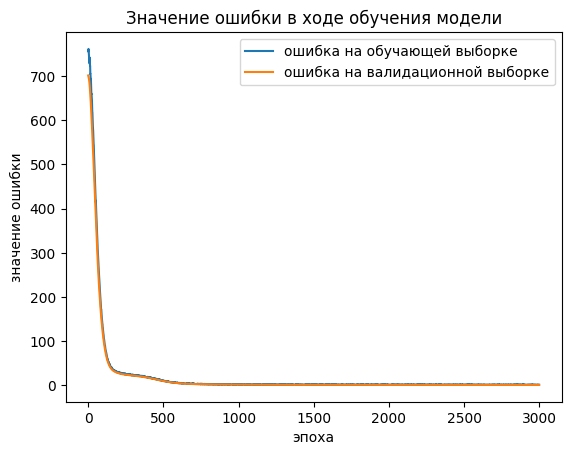

In [23]:
lstm_handler.plot_losses()  # вызов функции построения графиков изменения функции ошибки (обучающей, валидационной) в процессе обучения

Построим также график изменения ошибки предсказания в километрах на валидационной выборке в ходе обучения:

(0.0, 25.576409432876016)

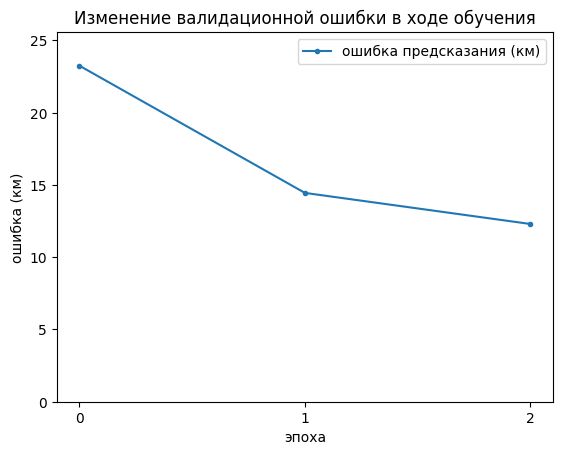

In [24]:
mean_hu_dists = np.mean(lstm_handler.distances, axis=(1, 2)) 
plt.title("Изменение валидационной ошибки в ходе обучения")  
plt.plot(mean_hu_dists, '.-', label="ошибка предсказания (км)") 
plt.legend() 
plt.xlabel('эпоха') 
plt.ylabel('ошибка (км)') 
plt.xticks(range(len(mean_hu_dists)), range(len(mean_hu_dists))) 
plt.ylim(0, 1.1 * np.max(mean_hu_dists)) 

Сохраним веса обученной модели в файл:

In [41]:
filename = './data/lstm_0.pkl' 
lstm_handler.save_model(filename) 

# Тестирование

Получим предскзания на тестовой выборке и оценим ошибку:

In [25]:
actual3d, predicted3d, test_loss = lstm_handler.evaluate(test_loader, seq_dim) 
base_pd = predicted3d  
np.mean(test_loss)  # вывод значения ошибки на тестовой выборке

1.1662332039533534

Определим вспомогательную функцию построения карты и траектории на ней:

In [26]:
def map_hurricane(plt_title):  # функция рисования карты с заданным заголовком
    plt.figure(figsize=(20, 16))  # задание размеров карты (в условных единицах)
    hm = Basemap(llcrnrlon=-100., llcrnrlat=0., 
                 urcrnrlon=20., urcrnrlat=60., 
                 projection='lcc', lat_1=0., lat_2=20., lon_0=-60., 
                 resolution='l', area_thresh=1000.) 
    hm.drawcoastlines() 
    hm.drawparallels(np.arange(-70, 70, 10), labels=[1, 1, 0, 0]) 
    hm.drawmeridians(np.arange(-110, 40, 10), labels=[0, 0, 0, 1])  
    plt.suptitle(plt_title, fontsize=64)  
    return hm  # возврат объекта нарисованной карты

Выведем фактическое и предскзаанное движение урагана:

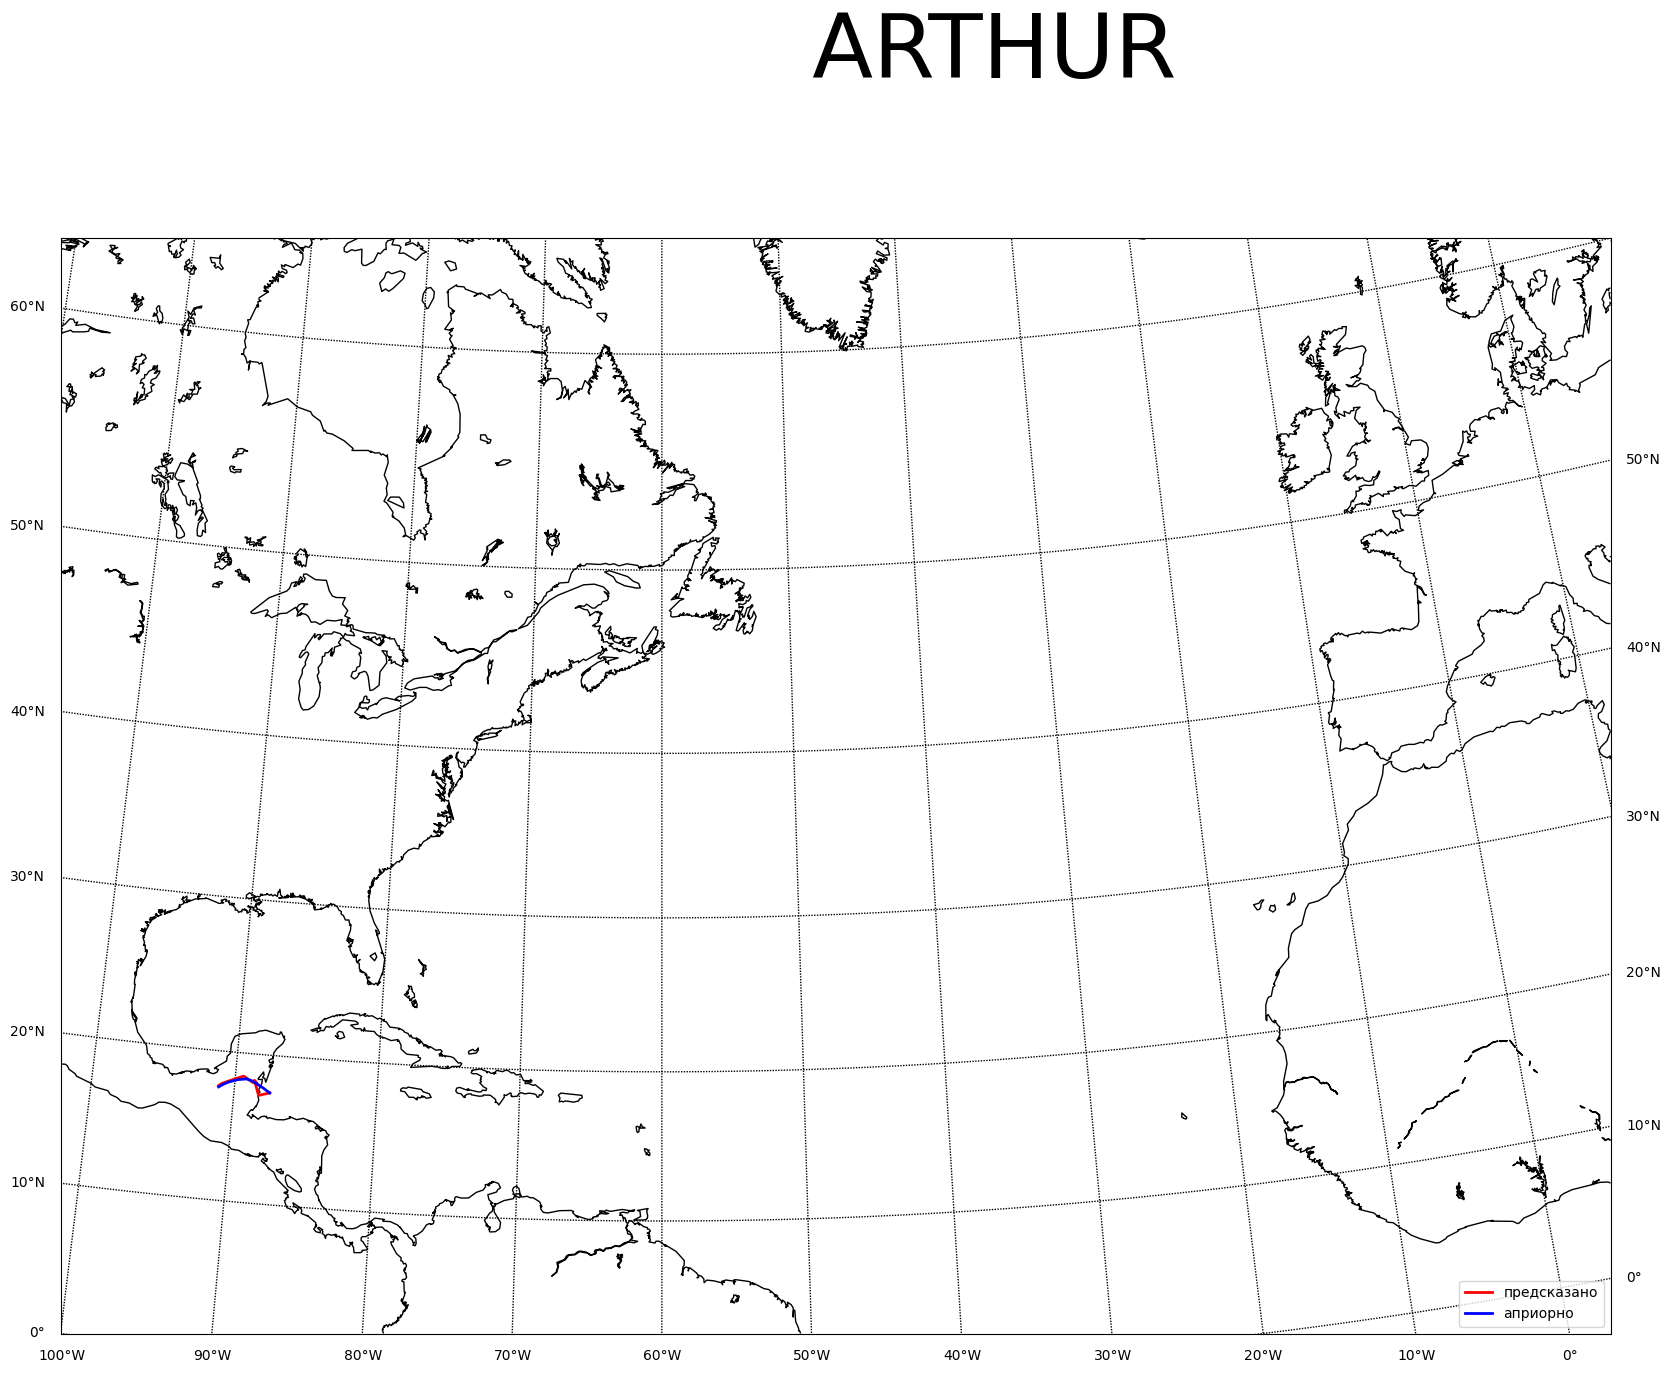

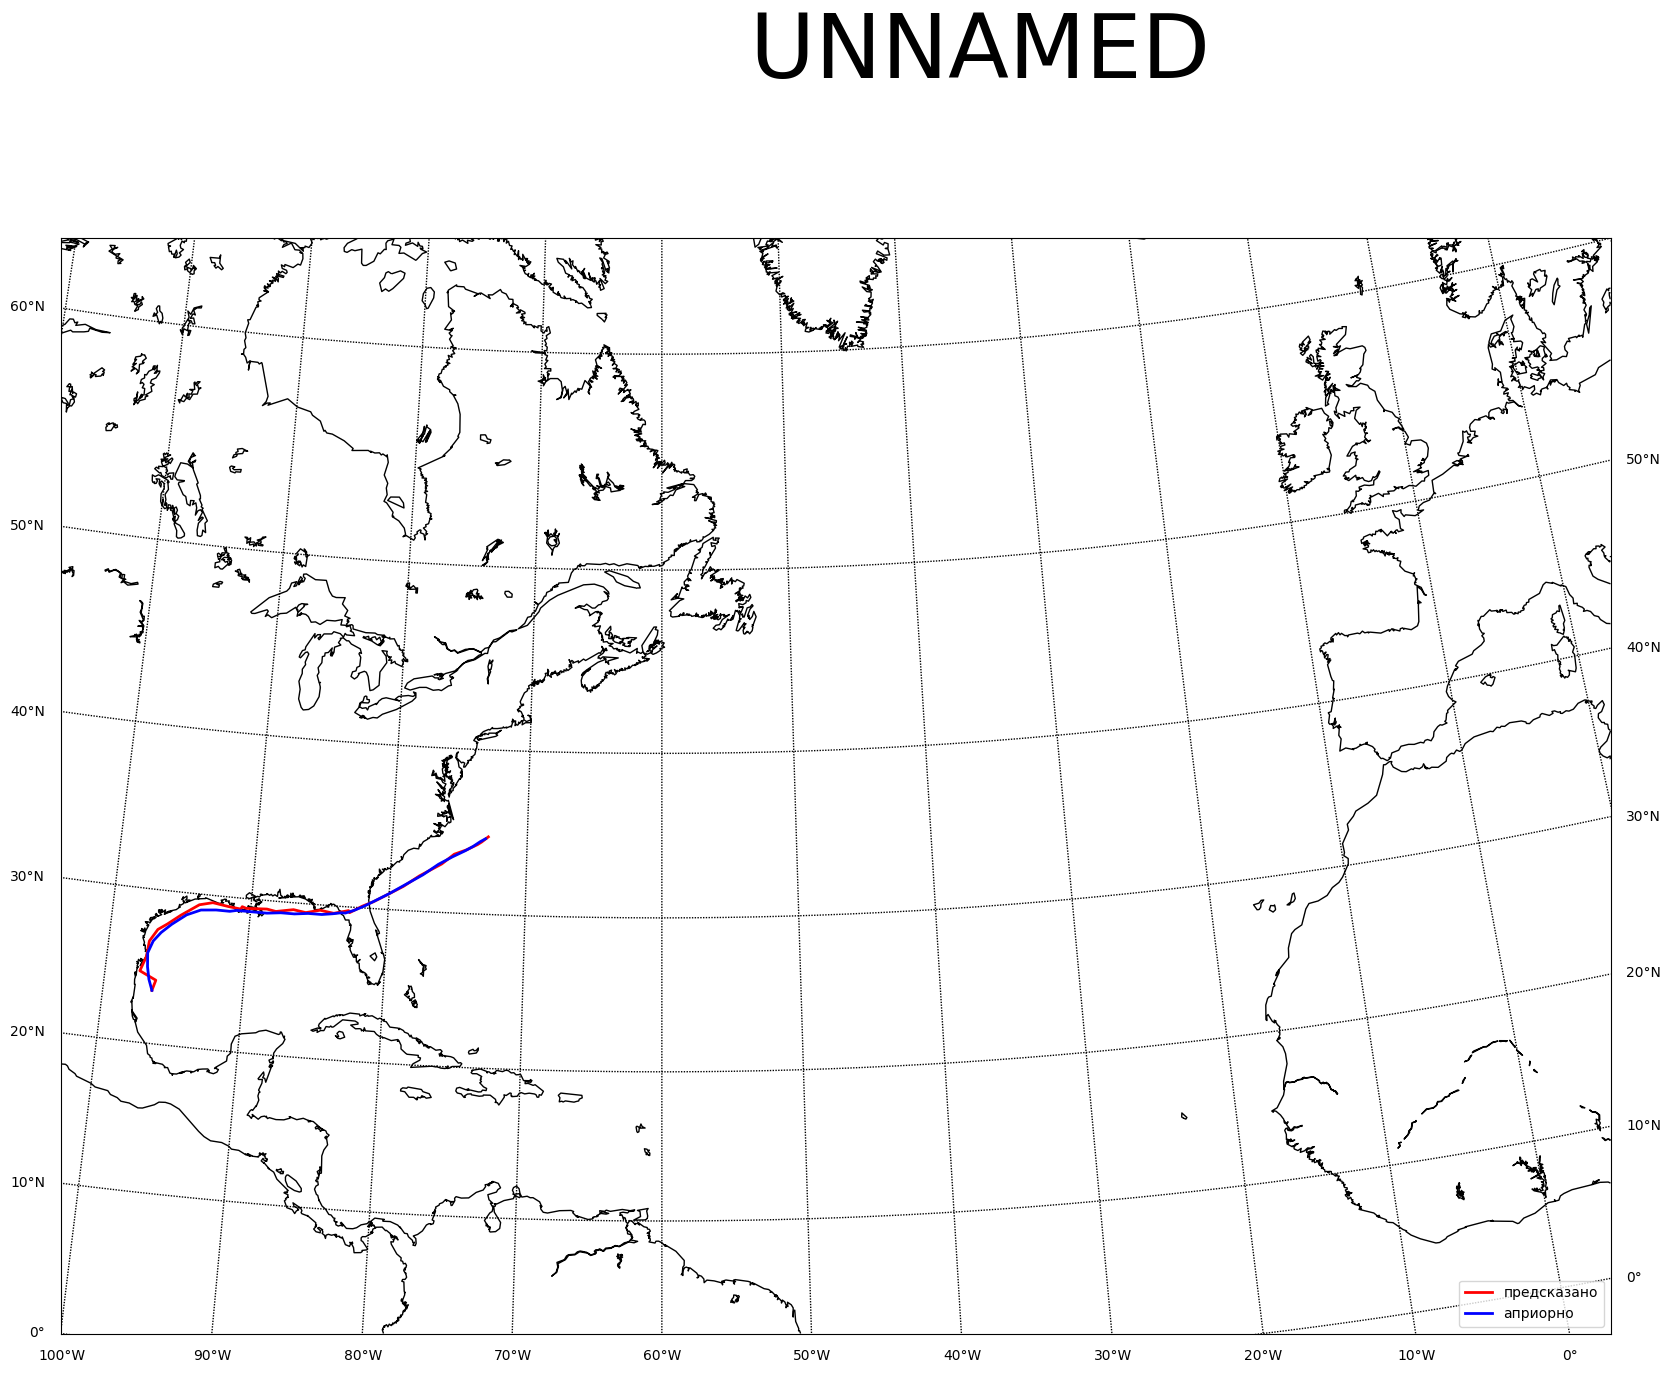

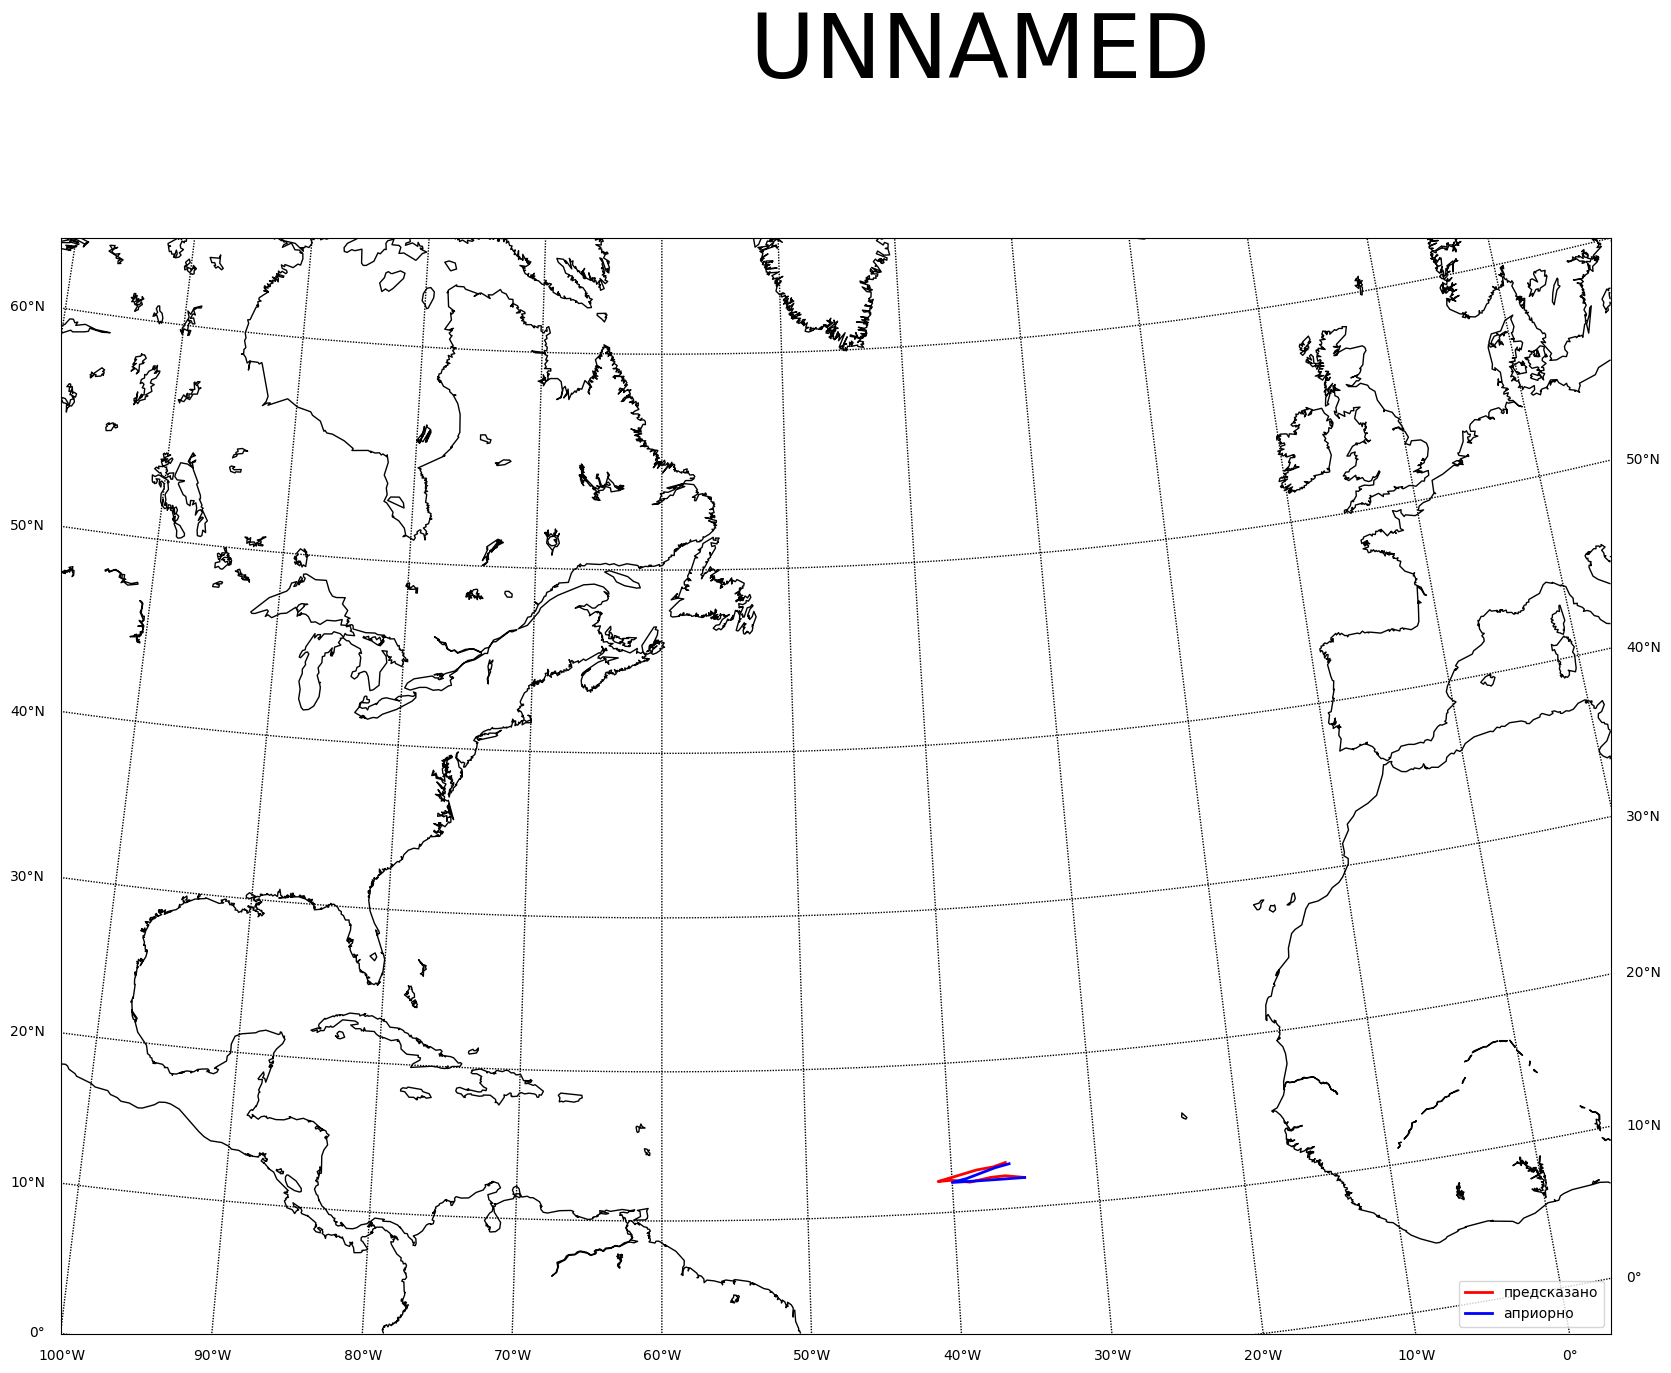

In [27]:
for idx in range(3):  # в цикле по первым 3 ураганам из тестовой выборки
    id2 = test_ids[idx] 
    storm_len = test_df.loc[test_df.ID == id2].shape[0]  
    origin = test_df.loc[test_df.ID == id2][['Latitude', 'Longitude']].iloc[0] 
    lat_pred = predicted3d[idx, :storm_len-1, 0]  
    lon_pred = predicted3d[idx, :storm_len-1, 1] 
    lat_actual = actual3d[idx, :storm_len-1, 0]  
    lon_actual = actual3d[idx, :storm_len-1, 1] 

    lat_pred = np.insert(lat_pred, 0, origin[0]) 
    lon_pred = np.insert(lon_pred, 0, origin[1]) 
    lat_actual = np.insert(lat_actual, 0, origin[0]) 
    lon_actual = np.insert(lon_actual, 0, origin[1]) 
    
    hu_name = test_df.loc[test_df.ID == id2, 'Name'].iloc[0]  
    hurricane_map = map_hurricane(hu_name) 
    x1, y1 = hurricane_map(lon_pred, lat_pred) 
    x2, y2 = hurricane_map(lon_actual, lat_actual) 

    plt.plot(x1, y1, '-', linewidth=2, color='red', label="предсказано")
    plt.plot(x2, y2, '-', linewidth=2, color='blue', label="априорно")

    plt.legend(loc="lower right")  
    plt.show()  # вывод карты

# Сравнение качества с другими моделями

Для данного датасета существуют другие реализации модели предсказания:

- регрессия с гардиентным бустингом (https://www.kaggle.com/code/plutsch/predicting-trajectories-of-caribbean-hurricanes),
- модель с несколькими слоями LSTM и блоком Dropout между вызовами LSTM (https://github.com/sheilaalemany/hurricane-rnn/blob/master/hurricane-rnn-sheils.ipynb),
- модель с двунаправленным и однонаправленным блоком LSTM (https://github.com/hammad93/hurricane-net/blob/main/hurricane-net.ipynb).

Для регрессии заявлена ошибка на уровне $22' \approx 0,37°$, что хуже достигнутого результата ($0,14°$).

Реализацию двух других моделей повторим и проверим в тех же условиях (тот же обучающий и тестовый датасеты, то же количество эпох).

Напомним, что модель в данной работе дала ошибку на тестовой выборке $\approx0,066$.

## Несколько блоков LSTM с Dropout

In [99]:
class SeqLSTM(nn.Module): 
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, device):
        super(SeqLSTM, self).__init__()  
        self.hidden_dim = hidden_dim  
        self.layer_dim = layer_dim 
        self.device = device 
        
        self.num_lstm = 4 
        dropout_rate = 0.1 
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.lstms = [nn.LSTM(hidden_dim, hidden_dim, layer_dim, batch_first=True).to(device)] 
        self.lstms.extend([ 
            nn.LSTM(hidden_dim, hidden_dim, layer_dim, batch_first=True).to(device)  
            for _ in range(self.num_lstm - 1) 
        ])
        self.dropouts = [
            nn.Dropout(dropout_rate).to(device) 
            for _ in range(self.num_lstm - 1) 
        ]
        self.fc = nn.Linear(hidden_dim, output_dim) 
    
    def forward(self, x): 
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device)  
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device) 
        
        out = self.fc_in(x) 
        for k in range(self.num_lstm - 1):
            cur, (hn, cn) = self.lstms[k](out, (h0, c0)) 
            out = out + self.dropouts[k](cur)  
        out, (hn, cn) = self.lstms[-1](out, (h0, c0)) 
        
        out = self.fc(out) 
        return out 

In [104]:
model = SeqLSTM(input_dim, 64, 1, output_dim, device)  
model.to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=120, verbose=True, factor=0.3)  

In [105]:
lstm_handler = LSTM_Handler(model, mse_loss_func, optimizer, scheduler) 
lstm_handler.train(train_loader, val_loader, batch_size, 3000, eval_step=1000, clip_loss=10000.0)

train loss=3.035666, val loss=2.503050: 100%|█████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:51<00:00, 17.52it/s, distance=127.55312 km]


In [106]:
actual3d, predicted3d, test_loss = lstm_handler.evaluate(test_loader, seq_dim)
mul_pd = predicted3d  
np.mean(test_loss)

2.3483422480894056

Модель освоила датасет, но имеет достаточно большую ошибку.

## Двунаправленный и однонаправленный блок LSTM

In [107]:
class BiLSTM(nn.Module): 
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, device):  
        super(BiLSTM, self).__init__()  
        self.hidden_dim = hidden_dim 
        self.layer_dim = layer_dim  
        self.device = device 
        
        self.bi_lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, 
                               batch_first=True, bidirectional=True)
        self.uni_lstm = nn.LSTM(2 * hidden_dim, hidden_dim, layer_dim, 
                                batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):  
        h0 = torch.zeros(2 * self.layer_dim, x.size(0), self.hidden_dim).to(self.device)  
        c0 = torch.zeros(2 * self.layer_dim, x.size(0), self.hidden_dim).to(self.device) 
        out, (hn, cn) = self.bi_lstm(x, (h0, c0)) 
        
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device)  
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device) 
        out, (hn, cn) = self.uni_lstm(out, (h0, c0)) 
        
        out = self.fc(out)  
        return out  

In [108]:
model = BiLSTM(input_dim, hidden_dim, layer_dim, output_dim, device)  
model.to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=120, verbose=True, factor=0.3) 

In [110]:
lstm_handler = LSTM_Handler(model, mse_loss_func, optimizer, scheduler)  
lstm_handler.train(train_loader, val_loader, batch_size, num_epochs, eval_step=1000, clip_loss=10000.0)  

train loss=0.888693, val loss=0.462110: 100%|██████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:53<00:00, 26.43it/s, distance=12.39763 km]


In [111]:
actual3d, predicted3d, test_loss = lstm_handler.evaluate(test_loader, seq_dim)
bi_pd = predicted3d  
np.mean(test_loss)  

0.29926471538502125

Эта модель показала удовлетворительный результат, но хуже, чем модель из данной работы.

## Модель с блоком GRU

In [115]:
class GRUmodel(nn.Module):  # модель с блоком GRU
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, device):
        super(GRUmodel, self).__init__()  
        self.hidden_dim = hidden_dim 
        self.layer_dim = layer_dim 
        self.device = device  
        
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim,  
                          batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x): 
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device) 
        out, hn = self.gru(x, h0)
        
        out = self.fc(out) 
        return out  # возврат предсказаний

In [116]:
model = GRUmodel(input_dim, hidden_dim, layer_dim, output_dim, device) 
model.to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=120, verbose=True, factor=0.3) 

In [117]:
lstm_handler = LSTM_Handler(model, mse_loss_func, optimizer, scheduler) 
lstm_handler.train(train_loader, val_loader, batch_size, num_epochs, eval_step=1000, clip_loss=10000.0)  

train loss=0.822449, val loss=0.409690: 100%|██████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:01<00:00, 49.15it/s, distance=19.51078 km]


In [118]:
actual3d, predicted3d, test_loss = lstm_handler.evaluate(test_loader, seq_dim)  
gru_pd = predicted3d  
np.mean(test_loss)  

0.1908326755632847

Модель показала близкие результаты относительно LSTM, но чуть хуже.

# Регрессия с градиентным бустингом

In [139]:
gb_x = train_x.reshape((-1, train_x.shape[-1]))  
gb_y = train_y.reshape((-1, train_y.shape[-1])) 
model_lat = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0, loss='squared_error'
                                      ).fit(gb_x, gb_y[:, 0]) 
model_lon = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0, loss='squared_error'
                                      ).fit(gb_x, gb_y[:, 1])  

gb_test_x = test_x.reshape((-1, test_x.shape[-1])) 
pd_lat = model_lat.predict(gb_test_x)  
pd_lon = model_lon.predict(gb_test_x)  
gb_pd = np.stack((pd_lat[:, None], pd_lon[:, None]), axis=1) 
gb_pd = gb_pd.reshape(test_y.shape)  
diff = np.linalg.norm(gb_pd - test_y, axis=2)  
np.mean(diff)  

0.2333508729271353

Модель показала ошибку, сравнимую с предыдущими моделями (пркатически самый лучший результат).

# Визуальное сравнение предсказаний

Построим визуализации предсказаний моедлей для 3 ураганов:

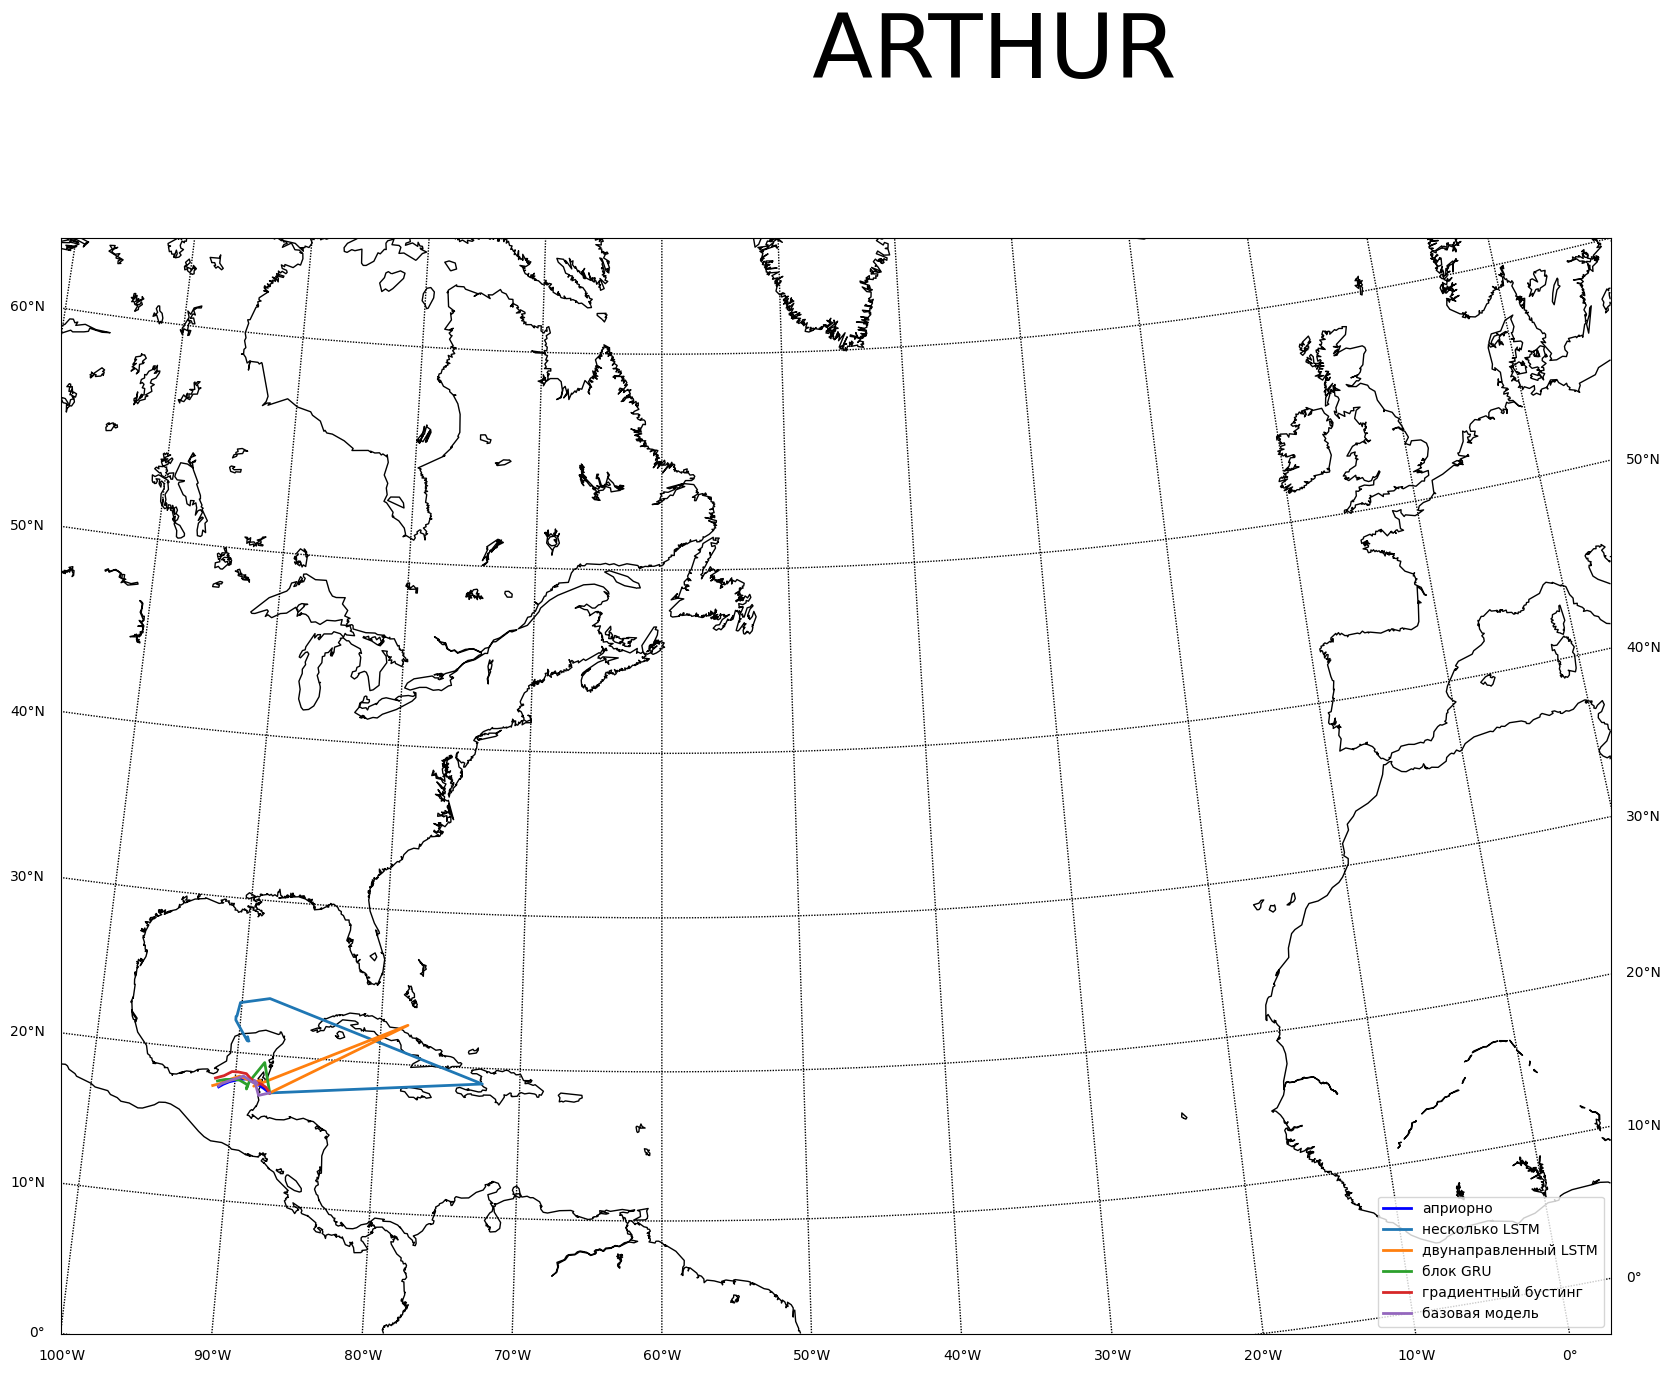

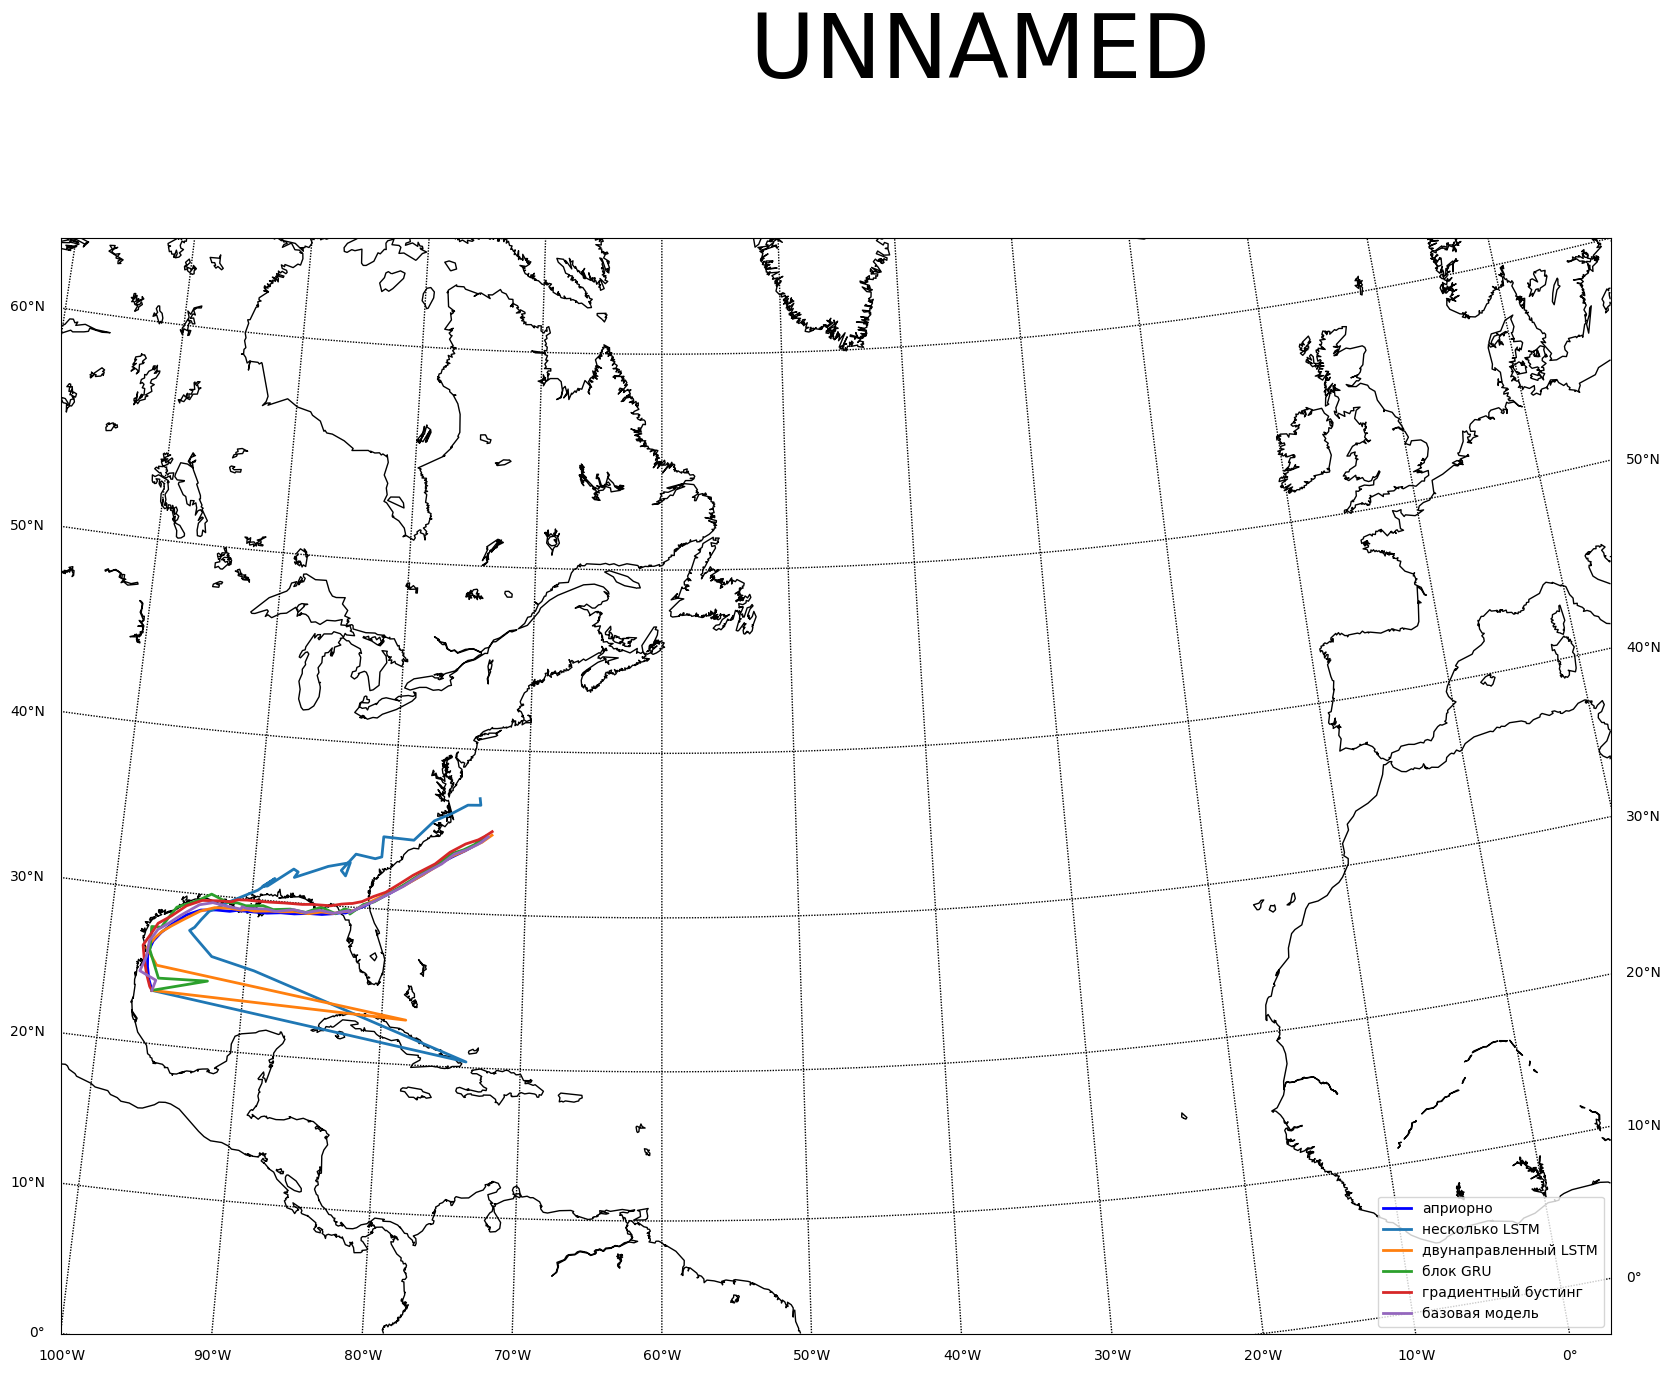

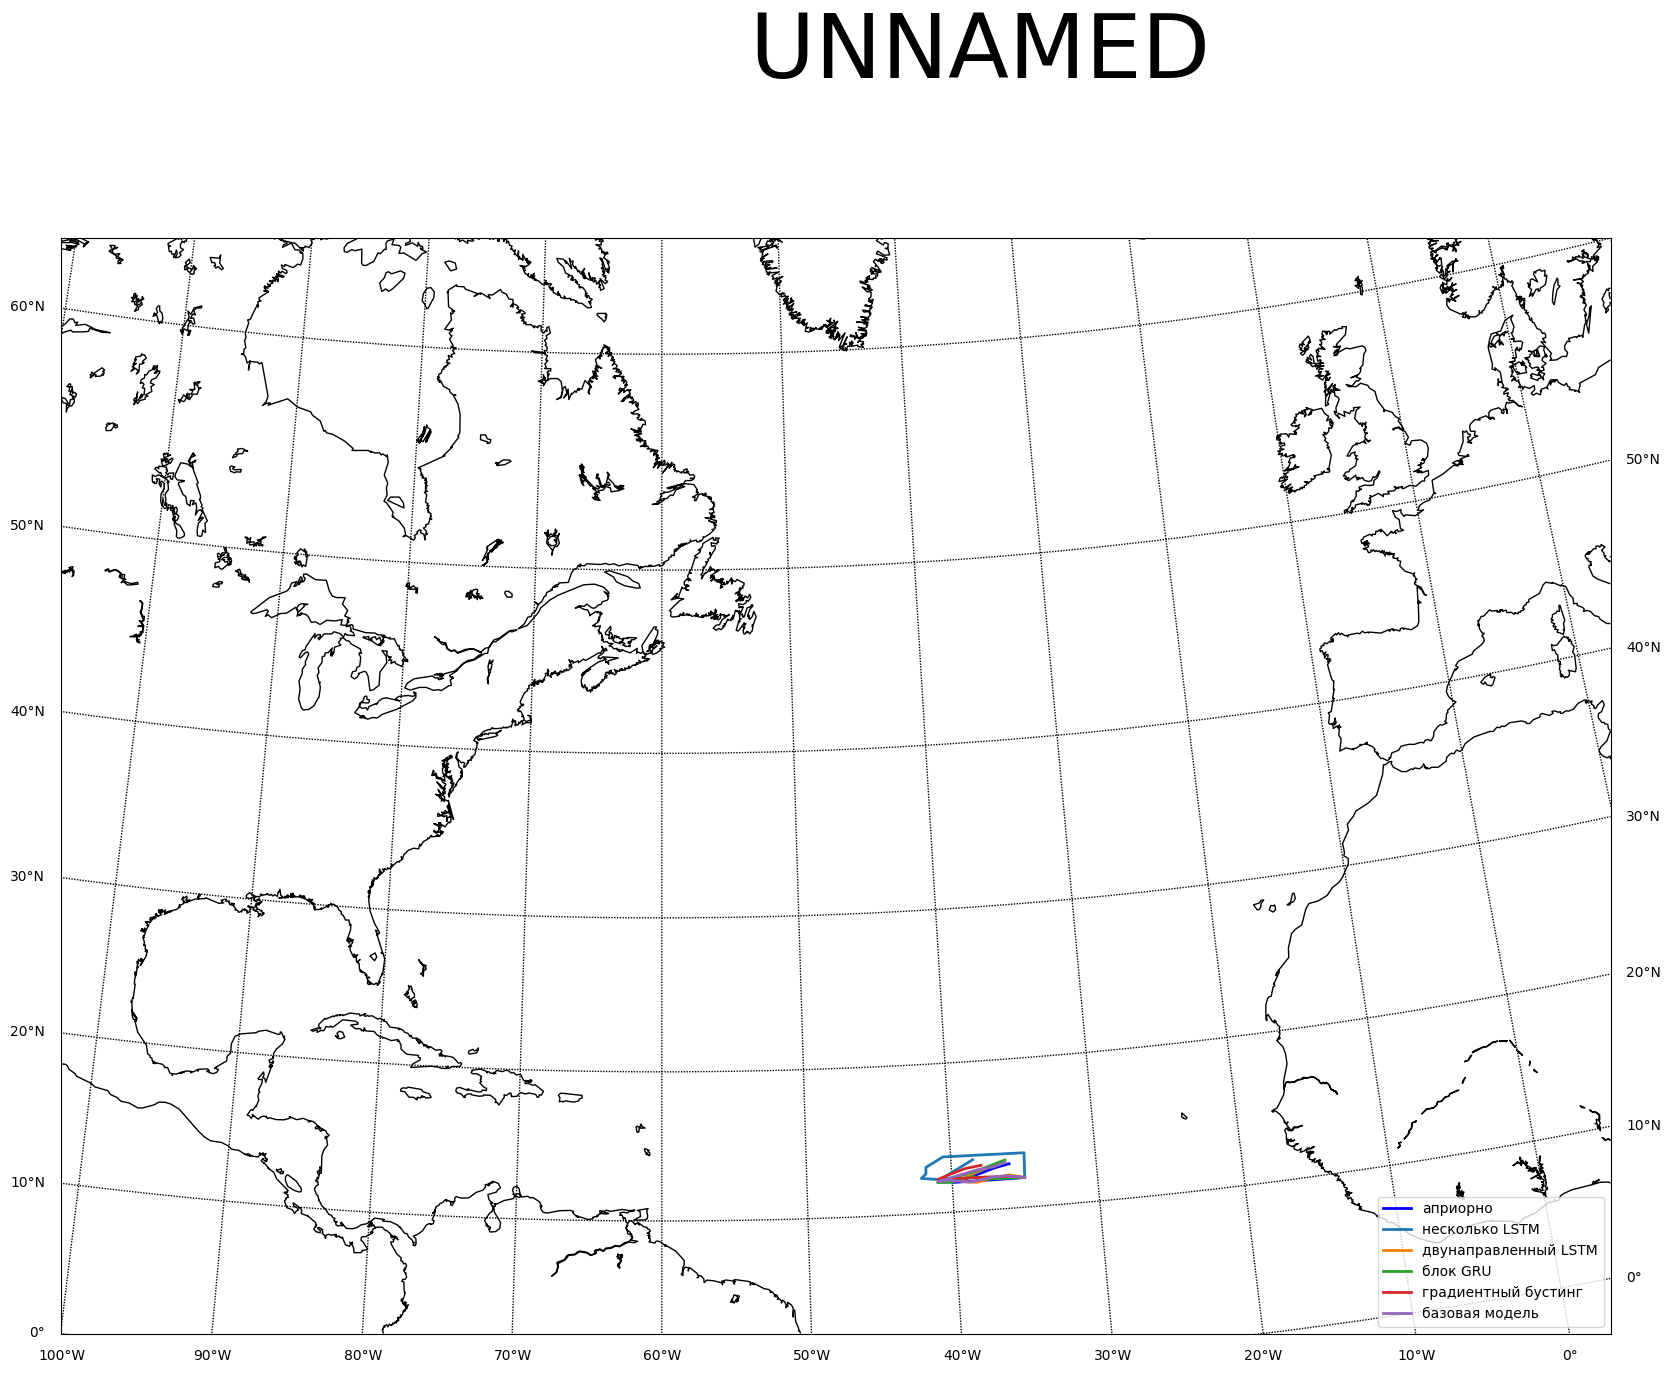

In [140]:
for idx in range(3): 
    id2 = test_ids[idx]  
    storm_len = test_df.loc[test_df.ID == id2].shape[0] 
    origin = test_df.loc[test_df.ID == id2][['Latitude', 'Longitude']].iloc[0] 
    lat_actual = actual3d[idx, :storm_len-1, 0] 
    lon_actual = actual3d[idx, :storm_len-1, 1] 
    lat_actual = np.insert(lat_actual, 0, origin[0]) 
    lon_actual = np.insert(lon_actual, 0, origin[1])
    
    hu_name = test_df.loc[test_df.ID == id2, 'Name'].iloc[0]  
    hurricane_map = map_hurricane(hu_name)
    x1, y1 = hurricane_map(lon_actual, lat_actual) 
    plt.plot(x1, y1, '-', linewidth=2, color='blue', label="априорно")

    for pd_set, pd_name in zip((mul_pd, bi_pd, gru_pd, gb_pd, base_pd), ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель')):
        lat_pred = pd_set[idx, :storm_len-1, 0]  
        lon_pred = pd_set[idx, :storm_len-1, 1] 
        lat_pred = np.insert(lat_pred, 0, origin[0])  
        lon_pred = np.insert(lon_pred, 0, origin[1])  
        x2, y2 = hurricane_map(lon_pred, lat_pred)  # преобразование координат предсказаний к масштабу карты,
        plt.plot(x2, y2, '-', linewidth=2, label=pd_name)  

    plt.legend(loc="lower right") 
    plt.show() 

Рассчитаем ошибку определения координат нескольких ураганов (среднее значение ошибки по всем точкам каждого урагана, в км):

In [144]:
def calc_pred_dist(gt_pts, pd_pts):  
    all_errors = []
    for gt_batch, pd_batch in zip(gt_pts, pd_pts): 
        all_errors.append([  
                distance(lonlat(gt_lon, gt_lat), 
                         lonlat(pd_lon, pd_lat)).km  
                for (gt_lat, gt_lon), (pd_lat, pd_lon) in zip(  
                     gt_batch, pd_batch  
                )
            ])
    return all_errors  

In [149]:
num_comp = 10  
comp_data = [ 
    [model_name, *np.mean(calc_pred_dist(actual3d, pd_pts), axis=1)[:num_comp]] 
    for model_name, pd_pts in zip(  
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель'), 
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd) 
    )
]
comp_columns = ['модель'] + [
    test_df.loc[test_df.ID == test_id, 'Name'].iloc[0]  
    for test_id in test_ids[:10]  # 
]  
comp_df = pd.DataFrame(comp_data, columns=comp_columns) 
comp_df 

,модель,ARTHUR,UNNAMED,UNNAMED,UNNAMED,UNNAMED,BERTHA,UNNAMED,UNNAMED,FIFI,UNNAMED
0,несколько LSTM,114.700329,154.396304,69.845679,99.596000,131.776304,93.706133,120.410890,74.974520,118.396450,179.851781
1,двунаправленный LSTM,14.552854,24.834570,5.645924,10.842271,4.519743,13.017913,8.681872,2.395083,4.585978,15.839516
2,блок GRU,7.490078,19.745739,9.361496,15.963111,14.778270,8.859455,26.729978,4.955696,12.304520,21.754303
3,градиентный бустинг,4.477824,24.636700,11.725453,23.043443,25.379847,7.192323,39.813126,2.857188,19.024646,35.506158
4,базовая модель,3.241036,10.514232,4.891829,13.823763,12.591127,5.110130,22.107854,2.809052,9.472955,15.996738


Теперь рассчитаем ошибку определения координат точек урагана для нескольких примеров (в гардусах по каждой географической координате и в км):

In [173]:
num_pts = 5  # количество точек урагана для сравнения
k = 0  # номер урагана
test_id, single_hu = test_ids[k], actual3d[k]  # ID урагана и его точки
comp_data = [ 
    [model_name, *(pd_pts[k] - single_hu)[:num_pts]]  
    for model_name, pd_pts in zip( 
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель'), 
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd) 
    )
]
hu_name = test_df.loc[test_df.ID == test_id, 'Name'].iloc[0] 
comp_columns = [hu_name] + [ 
    ('{}/широта'.format(k), '{}/долгота'.format(k)) 
    for k in range(num_pts)
] 
comp_df = pd.DataFrame(comp_data, columns=comp_columns) 
comp_df  

,ARTHUR,"(0/широта, 0/долгота)","(1/широта, 1/долгота)","(2/широта, 2/долгота)","(3/широта, 3/долгота)","(4/широта, 4/долгота)"
0,несколько LSTM,"[1.1600437, 15.360992]","[5.8240986, 0.16017151]","[5.290741, -1.7179413]","[4.2060223, -1.4799042]","[4.053797, -1.1417618]"
1,двунаправленный LSTM,"[4.80941, 9.909836]","[-0.041728973, -0.4558792]","[0.28376198, 0.17809296]","[-0.07286835, 0.12440491]","[0.0100803375, -0.10775757]"
2,блок GRU,"[1.6878204, -0.02796936]","[0.2255249, -0.79785156]","[-0.37182808, -0.748497]","[-0.28637695, -0.30490112]","[-0.12342453, -0.48303986]"
3,градиентный бустинг,"[0.04495407644233751, 0.20896068117635025]","[0.13799979430354625, 0.06979580654083861]","[0.12122446066661396, -0.1289512980727494]","[0.1323141854331169, -0.10770497747542152]","[0.3454799624854701, -0.04257300925586094]"
4,базовая модель,"[-0.5277767, -0.26584625]","[0.3524952, -0.4382553]","[0.063604355, -0.039848328]","[-0.09542847, 0.051971436]","[0.14869308, -0.18019867]"


In [176]:
comp_data = [  
    [model_name, *calc_pred_dist([single_hu], [pd_pts[k]])[0][:num_pts]]  
    for model_name, pd_pts in zip( 
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель'),  
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd)  
    )
]
hu_name = test_df.loc[test_df.ID == test_id, 'Name'].iloc[0]  
comp_columns = [hu_name] + [ 
    '{}/км'.format(k)  
    for k in range(num_pts)  
]  
comp_df = pd.DataFrame(comp_data, columns=comp_columns) 
comp_df 

,ARTHUR,0/км,1/км,2/км,3/км,4/км
0,несколько LSTM,1627.833832,645.032177,612.477029,490.610974,464.350475
1,двунаправленный LSTM,1164.016912,48.532906,36.627644,15.437288,11.446786
2,блок GRU,186.844626,88.100300,89.388647,45.240201,52.882135
3,градиентный бустинг,22.703893,16.968980,19.141508,18.552382,38.503202
4,базовая модель,64.874489,60.617495,8.207413,11.908098,25.169684


In [177]:
k = 5  # номер урагана
test_id, single_hu = test_ids[k], actual3d[k]  # ID урагана и его точки
comp_data = [  
    [model_name, *(pd_pts[k] - single_hu)[:num_pts]]  
    for model_name, pd_pts in zip(
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель'), 
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd) 
    )
]
hu_name = test_df.loc[test_df.ID == test_id, 'Name'].iloc[0]  
comp_columns = [hu_name] + [  
    ('{}/широта'.format(k), '{}/долгота'.format(k)) 
    for k in range(num_pts) 
]  
comp_df = pd.DataFrame(comp_data, columns=comp_columns)
comp_df 

,BERTHA,"(0/широта, 0/долгота)","(1/широта, 1/долгота)","(2/широта, 2/долгота)","(3/широта, 3/долгота)","(4/широта, 4/долгота)"
0,несколько LSTM,"[-5.1839104, 16.506775]","[-0.17098236, 2.248001]","[0.15204811, -0.59465027]","[0.70643616, -0.32334137]","[0.3945427, -0.43894196]"
1,двунаправленный LSTM,"[-4.027628, 9.776428]","[0.16827011, 0.1660614]","[-0.0029201508, 0.10273743]","[-0.082883835, -0.042297363]","[0.0626812, 0.0012130737]"
2,блок GRU,"[0.39360046, 0.6367874]","[0.09377861, 0.48129272]","[0.19571686, 0.57761383]","[0.20009422, 0.48820496]","[-0.08728409, 0.061203003]"
3,градиентный бустинг,"[0.4044413201795649, 0.23343295358640148]","[0.4396847202906109, 0.32268162940155776]","[0.3002744257843588, 0.21251801269006876]","[0.2658310163519708, 0.16476216508465313]","[0.2548834726466289, 0.49893484494084817]"
4,базовая модель,"[0.4994564, 0.43249512]","[0.25157738, 0.17246246]","[-0.11990547, 0.063690186]","[-0.024944305, 0.12975311]","[0.070085526, 0.104148865]"


In [178]:
comp_data = [  
    [model_name, *calc_pred_dist([single_hu], [pd_pts[k]])[0][:num_pts]]  
    for model_name, pd_pts in zip( 
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель'),
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd)  
    )
]
hu_name = test_df.loc[test_df.ID == test_id, 'Name'].iloc[0] 
comp_columns = [hu_name] + [ 
    '{}/км'.format(k)  
    for k in range(num_pts)  
] 
comp_df = pd.DataFrame(comp_data, columns=comp_columns)
comp_df  

,BERTHA,0/км,1/км,2/км,3/км,4/км
0,несколько LSTM,1768.163349,224.092772,61.240254,84.515141,61.448122
1,двунаправленный LSTM,1082.690208,24.877820,10.184364,10.091325,6.947154
2,блок GRU,76.700327,48.868314,61.153690,53.052580,11.399974
3,градиентный бустинг,50.430717,58.270210,39.360695,33.647748,56.652495
4,базовая модель,69.981871,32.702344,14.710078,13.117166,12.867987


In [179]:
k = 8  
test_id, single_hu = test_ids[k], actual3d[k]  
comp_data = [
    [model_name, *(pd_pts[k] - single_hu)[:num_pts]] 
    for model_name, pd_pts in zip(  
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель'),  
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd)
    )
]
hu_name = test_df.loc[test_df.ID == test_id, 'Name'].iloc[0]  
comp_columns = [hu_name] + [  # список столбцов
    ('{}/широта'.format(k), '{}/долгота'.format(k))
    for k in range(num_pts)  
]  
comp_df = pd.DataFrame(comp_data, columns=comp_columns)
comp_df  

,FIFI,"(0/широта, 0/долгота)","(1/широта, 1/долгота)","(2/широта, 2/долгота)","(3/широта, 3/долгота)","(4/широта, 4/долгота)"
0,несколько LSTM,"[0.3596201, 6.726288]","[0.46094608, 1.2791557]","[0.015029907, 0.07645416]","[-0.20198727, -0.4564743]","[-0.31813622, -0.32025146]"
1,двунаправленный LSTM,"[0.024370193, 0.1668129]","[-0.011096954, 0.10160828]","[-0.13407516, 0.30407715]","[-0.20779228, 0.16942596]","[-0.025119781, 0.0820961]"
2,блок GRU,"[-0.00053977966, 1.118042]","[-0.8104162, 0.054107666]","[-0.3511219, 0.5152397]","[-0.0029916763, -0.17588806]","[-0.008122444, -0.37813568]"
3,градиентный бустинг,"[-0.3045903733018829, 0.5954060452917673]","[-0.5589391121406209, 0.4933885114134995]","[-0.6669896298797013, 0.7139475515251164]","[-0.7222369848686565, 0.5717283311444277]","[-0.5518257728017879, 0.19175097414630216]"
4,базовая модель,"[-0.27365017, 0.6916237]","[-0.50675964, 0.0879097]","[-0.56176186, 0.01241684]","[-0.22250271, 0.10316849]","[0.08200073, -0.038963318]"


In [180]:
comp_data = [ 
    [model_name, *calc_pred_dist([single_hu], [pd_pts[k]])[0][:num_pts]]
    for model_name, pd_pts in zip(  
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель'),
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd)
    )
]
hu_name = test_df.loc[test_df.ID == test_id, 'Name'].iloc[0] 
comp_columns = [hu_name] + [  
    '{}/км'.format(k)  
    for k in range(num_pts)  
] 
comp_df = pd.DataFrame(comp_data, columns=comp_columns)  
comp_df 

,FIFI,0/км,1/км,2/км,3/км,4/км
0,несколько LSTM,736.698351,148.517120,8.477986,54.255895,49.330330
1,двунаправленный LSTM,18.451953,11.157226,36.247109,29.414799,9.280080
2,блок GRU,122.349915,89.838766,68.204959,19.045247,40.790492
3,градиентный бустинг,73.379997,82.022699,107.173931,101.128480,64.469305
4,базовая модель,81.545061,56.872162,62.158615,27.033935,9.998327
